# Import Library

In [341]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from skimage import io  # Using scikit-image to process image
from enum import Enum
import os


In [493]:
class Config(Enum):
    num_hidden = 64
    num_component = 2
    learning_rate = 0.01
    random_seed = 714
    epoch = 512


class ImageType(Enum):
    Carambula = 0
    Lychee = 1
    Pear = 2


def rng_generator():
    return np.random.default_rng(Config.random_seed.value)


pca = PCA(n_components=Config.num_component.value)


# Read image & reduce dimension

In [398]:
class ImageLoader:
    def __init__(self, dir, split) -> None:
        self.split = split
        self.dir = os.path.join(
            dir, "Data_train" if split == "train" else "Data_test"
        )

        self.images = []
        self.labels = []

        for index in ImageType:
            images_path = os.path.join(self.dir, index.name, "*.png")
            images = io.imread_collection(images_path).concatenate() / 255

            self.images.extend(images)
            self.labels.extend([index.value for _ in images])

        self.images_pca = self.__get_PCA_images()

    def __get_PCA_images(self):
        self.images_reshape = [image.flatten() for image in self.images]

        if self.split == "train":
            images_pca = list(pca.fit_transform(self.images_reshape))
        else:
            images_pca = list(pca.transform(self.images_reshape))

        return [image.reshape(-1, 1) for image in images_pca]

    def get(self):
        return self.images_pca, self.labels


In [399]:
train_x, train_y = ImageLoader(".", "train").get()
test_x, test_y = ImageLoader(".", "test").get()


# NN Model

In [400]:
class Activation:
    def ReLU(self, x):
        return np.maximum(0, x)

    def ReLU_derivative(self, x):
        return (x > 0) * 1

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - self.tanh(x) ** 2

    def get(self, type: str):
        if type == "sigmoid":
            return self.sigmoid, self.sigmoid_derivative
        elif type == "ReLU":
            return self.ReLU, self.ReLU_derivative
        elif type == "tanh":
            return self.tanh, self.tanh_derivative


def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x)


In [478]:
class NN:
    def __init__(self, size: list, activation_type="sigmoid") -> None:
        self.size = size
        self.num_layer = len(size)

        self.bias = [rng.random((i, 1)) for i in size[1:]]
        self.weights = [rng.random((j, k)) for k, j in zip(size[:-1], size[1:])]

        self.acti_func, self.acti_derivative = Activation.get(
            Activation(), activation_type
        )

    def cost_derivative(self, label, pred):
        pred[label] = pred[label] - 1
        return pred

    def loss_func(self, label, pred):
        pred[label] = pred[label] - 1
        return np.mean(pred**2)

    def shuffle_data(self, features, labels):
        combine = list(zip(features, labels))
        rng.shuffle(combine)
        return zip(*combine)

    def feed_forward(self, feature: np.ndarray) -> np.ndarray:
        # Initial declare the variable
        activation = feature
        activations = [activation]
        zs = []

        # Hidden layer
        for b, w in zip(self.bias, self.weights):
            z = np.dot(w, activation) + b
            activation = self.acti_func(z)

            zs.append(z)
            activations.append(activation)

        # Output layer
        activations[-1] = softmax(activations[-1])

        return zs, activations

    def back_propagation(self, feature, label, learning_rate):
        zs, activations = self.feed_forward(feature)
        weight_gradient = [np.zeros(w.shape) for w in self.weights]
        bias_gradient = [np.zeros(b.shape) for b in self.bias]

        sensitivity = self.cost_derivative(
            label, activations[-1]
        ) * self.acti_derivative(zs[-1])

        bias_gradient[-1] = sensitivity
        weight_gradient[-1] = np.dot(sensitivity, activations[-2].T)

        for l in range(2, self.num_layer):
            sensitivity = np.dot(
                self.weights[-l + 1].T, sensitivity
            ) * self.acti_derivative(zs[-l])

            bias_gradient[-l] = sensitivity
            weight_gradient[-l] = np.dot(sensitivity, activations[-l - 1].T)

        self.bias = [
            b - learning_rate * b_gradient
            for b, b_gradient in zip(self.bias, bias_gradient)
        ]

        self.weights = [
            w - learning_rate * w_gradient
            for w, w_gradient in zip(self.weights, weight_gradient)
        ]

        self.batch_loss.append(self.loss_func(label, activations[-1]))

    def train(self, features, labels, learning_rate, epoch):
        self.loss = []
        for _ in range(epoch):
            self.batch_loss = []
            features, labels = self.shuffle_data(features, labels)
            for label, feature in zip(labels, features):
                self.back_propagation(feature, label, learning_rate)
            self.loss.append(np.mean(self.batch_loss))

    def pred(self, test_features):
        test_result = [
            np.argmax(self.feed_forward(feature)[1][-1])
            for feature in test_features
        ]

        return test_result

    def plot_loss_curve(self):
        plt.plot(range(len(self.loss)), self.loss)
        plt.show()


In [494]:
rng = rng_generator()

model = NN(
    [Config.num_component.value, Config.num_hidden.value, len(ImageType)],
    "ReLU",
)
model.train(train_x, train_y, Config.learning_rate.value, Config.epoch.value)
pred_y = model.pred(test_x)


Accuracy: 88.353%


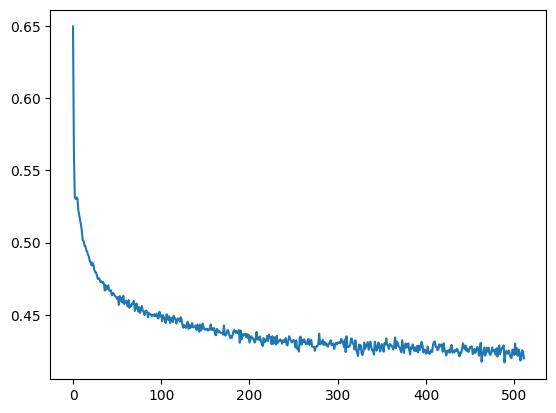

In [495]:
def evaluate(pred_y, test_y):
    corr = [(pred == test) * 1 for pred, test in zip(pred_y, test_y)]
    return np.mean(corr)


print(f"Accuracy: {evaluate(pred_y, test_y) * 100:.3f}%")
model.plot_loss_curve()
